# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed  # force n2 import to avoid libgomp issue https://github.com/kakao/n2/issues/42

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Amazon-GoogleProducts](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). The dataset is stored in a ZIP file with 3 CSV files: Two are the entity source files, the third one is the perfect mapping.

Let's download the ZIP:

In [6]:
import urllib
import tempfile

dataset_url = 'https://dbs.uni-leipzig.de/file/Amazon-GoogleProducts.zip'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Extracting the files:

In [7]:
import zipfile
import os

td = tempfile.TemporaryDirectory()

with zipfile.ZipFile(tf.name, "r") as zf:
    zf.extractall(td.name)

os.listdir(td.name)

['Amazon.csv', 'GoogleProducts.csv', 'Amzon_GoogleProducts_perfectMapping.csv']

Now we must read the **two** CSV files `'Amazon.csv'` and `'GoogleProducts.csv'` into a **single** `dict` called `row_dict`. Therefore, `row_dict` will contain all rows from the dataset, i.e., all rows from both files.

We'll dynamically attribute an ID for each row using `enumerate`. entity-embed needs that too.

Also, to keep track of the IDs of each source file, we must keep a `left_id_set` and a `right_id_set`.

In [8]:
import csv

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
left_id_set = set()
right_id_set = set()

with open(f'{td.name}/Amazon.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['name'] = row.pop('title')  # in Amazon, name is called title
        row['__source'] = 'amazon'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        left_id_set.add(row['id'])

with open(f'{td.name}/GoogleProducts.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['__source'] = 'google'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        right_id_set.add(row['id'])

Now we compute the `true_pair_set`:

In [9]:
true_pair_set = set()

with open(f'{td.name}/Amzon_GoogleProducts_perfectMapping.csv', newline='') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        true_pair_set.add((id_left, id_right))

len(true_pair_set)

1300

Note internally entity-embed will use **clusters, not pairs**.

For this dataset, the number of clusters is smaller than the number of pairs, because some clusters have more than 2 entities. For example, a cluster with 3 entities means 2 entities from a file link to 1 row from the other file. This is not a problem for entity-embed. In fact, it's important for entity-embed to know the full clusters in order to learn better embeddings. See an example here:

In [10]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_dict)

1105

In [11]:
cluster_dict[262]

[262, 2485, 2488]

In [12]:
for id_ in cluster_dict[262]:
    display(row_dict[id_])

{'id': 262,
 'description': 'sp linux we 50 lic/cd 3.0c',
 'manufacturer': 'hewlett packard (consumables)',
 'price': '0',
 'name': 'hp sp linux we 50 lic/cd 3.0c ( t3586a )',
 '__source': 'amazon'}

{'id': 2485,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

{'id': 2488,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

Note that there are additional pairs in clusters when compared to `true_pair_set`. That's because it's useful for entity-embed to also learn that cases like `(2485, 2488)` represent the same entity, even though they belong to the same dataset and won't be returned in the final pairwise results.

In [13]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

len(cluster_dict_to_id_pairs(cluster_dict) - true_pair_set)

253

Clean up the temporary files:

In [14]:
import os

td.cleanup()
os.remove(tf.name)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, strip leading and trailing whitespace, and limit any value to 100 tokens and 1000 chars to avoid memory errors.

The fields we'll clean are the ones we'll use:

In [15]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [16]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for row in row_dict.values():
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

It's worth noting you can use any alphabet you need, so this accent removal is optional.

## Configure entity-embed attributes

Now we will define how row fields (entity attributes) will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [17]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

Then we set an `attr_info_dict`. It defines types, which determine how attributes are processed in the neural network:

In [18]:
attr_info_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_name': {
        'source_attr': 'name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_description': {
        'source_attr': 'description',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    }
}

In [19]:
import json

with open('../example-data/rl-example-attr-info.json', 'w') as f:
    json.dump(attr_info_dict, f, indent=4)

Then we use our `attr_info_dict` to get a `row_numericalizer`.

The same `row_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Also, one must keep this `row_numericalizer` to use on production data:

In [20]:
from entity_embed import AttrInfoDictParser

row_numericalizer = AttrInfoDictParser.from_dict(attr_info_dict, row_list=row_dict.values())
row_numericalizer.attr_info_dict

18:16:34 INFO:For attr=name, computing actual max_str_len
18:16:34 INFO:For attr=name, using actual_max_str_len=26
18:16:34 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
18:16:38 INFO:For attr=description, computing actual max_str_len
18:16:38 INFO:actual_max_str_len=29 must be even to enable NN pooling. Updating to 30
18:16:38 INFO:For attr=description, using actual_max_str_len=30
18:16:38 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
18:16:41 INFO:For attr=manufacturer, computing actual max_str_len
18:16:41 INFO:actual_max_str_len=15 must be even to enable NN pooling. Updating to 16
18:16:41 INFO:For attr=manufacturer, using actual_max_str_len=16
18:16:41 INFO:For attr=price, computing actual max_str_len
18:16:41 INFO:For attr=price, using actual_max_str_len=14


{'name': NumericalizeInfo(source_attr='name', field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=26, vocab=None, n_channels=8, embed_dropout_p=0.2, use_attention=True, use_mask=True),
 'semantic_name': NumericalizeInfo(source_attr='name', field_type=<FieldType.SEMANTIC_MULTITOKEN: 'semantic_multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',

## Initialize Data Module

Under the hoods entity-embed uses [pytorch-lightning](https://www.pytorchlightning.ai/), so we need to create a datamodule object to split our dataset between train, valid, and test data.

In [21]:
clusters_total = len(cluster_dict)
clusters_total

1105

Since there's a lot of clusters, we'll use only 200 for training, and other 200 for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data for record linkage.

In [22]:
from entity_embed import LinkageDataModule

train_cluster_len = 200
valid_cluster_len = 200
batch_size = 20
eval_batch_size = 50
datamodule = LinkageDataModule(
    row_dict=row_dict,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    row_numericalizer=row_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    true_pair_set=true_pair_set,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    random_seed=random_seed
)

We've used `LinkageDataModule` because we're doing Record Linkage of a multiple datasets/tables.

We're NOT doing Deduplication of a single dataset here. Check the other notebook Deduplication if you want to learn how to do it with entity-embed.

## Training

Now the training process! Thanks to pytorch-lightining, it's easy to train, validate, and test with the same datamodule.

We must choose the approximate nearest neighbors K, i.e., the top N our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [23]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    row_numericalizer,
    ann_k=ann_k,
    eval_with_clusters=True
)

Also, we set `eval_with_clusters` to `True`, which is the default. This means we'll evaluate the model considering the [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)) of the found pairs.

Connected components are the simplest way to remove ambiguity from Entity Resolution pairs, because it ensures the transitivity. For example, imagine the pairs (A, B), (B, C) are found, but not (A, C). The easiest way to resolve this is to connect all records that have a path between them. That's the connected components of the graph of pairs.

Returning connected components makes sense for Blocking, which is the main purpose of Entity Embed, as it allows us to segment the records into blocks. By computing the components, each record can be assigned to cluster ID.

Inspecting the model will reveal it's built based on the attributes we set on `attr_info_dict`: 

In [24]:
model

LinkageEmbed(
  (blocker_net): BlockerNet(
    (embedding_net_dict): ModuleDict(
      (name): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (dense_net): Sequential(
            (0): Linear(in_features=7176, out_features=300, bias=True)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (semantic_name): MultitokenAttentionEmbed(
        (embedding_net): SemanticEmbedNet(
          (dense_net): Sequential(
            (0): Embedding(5565, 300)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (description): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1

To train, we use a [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/1.1.6/trainer.html).

To strike a balance between precision and recall, we'll use the metric `valid_f1_at_0.5` for early stopping.

`0.5` here is the threshold for cosine similarity of embedding vectors. Note we're using a validation metric, as the training process will run validation on every epoch due to `check_val_every_n_epoch=1`.

We also set a `TensorBoardLogger`, thus you can use `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics.

In [25]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_f1_at_0.5',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_save_dir = 'tb_logs'
tb_name = 'amazon-google'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_save_dir, name=tb_name),
    reload_dataloaders_every_epoch=True
)

GPU available: True, used: True
18:16:41 INFO:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
18:16:41 INFO:TPU available: None, using: 0 TPU cores


OK, all set, call `fit`!

In [26]:
trainer.fit(model, datamodule)

18:16:41 INFO:Train pair count: 233
18:16:41 INFO:Valid pair count: 236
18:16:41 INFO:Test pair count: 831
18:16:41 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)
18:17:38 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Now training is done, we can easily check which attributes are most important for the final embedding:

In [27]:
model.blocker_net.get_signature_weights()

{'name': 0.22408625483512878,
 'semantic_name': 0.2346668243408203,
 'description': 0.19450458884239197,
 'semantic_description': 0.17109224200248718,
 'manufacturer': 0.0896478146314621,
 'price': 0.08600234240293503}

And we can check the best validation model:

In [28]:
from entity_embed import validate_best

validate_best(trainer)

18:31:35 INFO:Validating best model...


{'valid_f1_at_0.3': 0.012402364365632256,
 'valid_f1_at_0.5': 0.4807903402854006,
 'valid_f1_at_0.7': 0.7417218543046357,
 'valid_f1_at_0.9': 0.4516129032258064,
 'valid_pair_entity_ratio_at_0.3': 86.57471264367815,
 'valid_pair_entity_ratio_at_0.5': 1.5517241379310345,
 'valid_pair_entity_ratio_at_0.7': 0.49885057471264366,
 'valid_pair_entity_ratio_at_0.9': 0.17011494252873563,
 'valid_precision_at_0.3': 0.006240042485395645,
 'valid_precision_at_0.5': 0.3244444444444444,
 'valid_precision_at_0.7': 0.7741935483870968,
 'valid_precision_at_0.9': 0.9459459459459459,
 'valid_recall_at_0.3': 0.9957627118644068,
 'valid_recall_at_0.5': 0.9279661016949152,
 'valid_recall_at_0.7': 0.711864406779661,
 'valid_recall_at_0.9': 0.2966101694915254}

## Testing

With the best validation model (`ckpt_path='best'`), we can check the performance on the test set: 

In [29]:
trainer.test(ckpt_path='best', verbose=False)

18:31:41 INFO:Train pair count: 233
18:31:41 INFO:Valid pair count: 236
18:31:41 INFO:Test pair count: 831
18:31:41 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_f1_at_0.3': 0.0028645107211327805,
  'test_f1_at_0.5': 0.02000436552264294,
  'test_f1_at_0.7': 0.46940298507462686,
  'test_f1_at_0.9': 0.33151432469304226,
  'test_pair_entity_ratio_at_0.3': 375.3776041666667,
  'test_pair_entity_ratio_at_0.5': 50.1640625,
  'test_pair_entity_ratio_at_0.7': 1.2037760416666667,
  'test_pair_entity_ratio_at_0.9': 0.4134114583333333,
  'test_precision_at_0.3': 0.0014343196087273232,
  'test_precision_at_0.5': 0.01011005554690339,
  'test_precision_at_0.7': 0.34018388318009735,
  'test_precision_at_0.9': 0.3826771653543307,
  'test_recall_at_0.3': 0.9951865222623345,
  'test_recall_at_0.5': 0.937424789410349,
  'test_recall_at_0.7': 0.7569193742478941,
  'test_recall_at_0.9': 0.2924187725631769}]

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `row_dict`:

In [30]:
test_row_dict = datamodule.test_row_dict
test_left_id_set = set(id_ for id_ in left_id_set if id_ in test_row_dict)
test_right_id_set = set(id_ for id_ in right_id_set if id_ in test_row_dict)

Keep the `test_true_pair_set` in a variable for evaluation:

In [31]:
test_true_pair_set = datamodule.test_true_pair_set

Before testing manually, do some cleanup:

In [32]:
import gc
del trainer
del datamodule
gc.collect()
torch.cuda.empty_cache()

Then call `predict`:

In [33]:
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    left_id_set=test_left_id_set,
    right_id_set=test_right_id_set,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/31 [00:00<?, ?it/s]

Double-check if returned embeddings on `test_left_vector_dict` and `test_right_vector_dict` have the same length of `test_row_dict`:

In [34]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

Now init an `ANNLinkageIndex`, insert all embeddings from both `test_left_vector_dict` and `test_right_vector_dict` on it, and build it:

In [35]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 716 ms, sys: 0 ns, total: 716 ms
Wall time: 106 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [52]:
%%time
from entity_embed.data_utils import utils

sim_threshold = 0.5
__, found_cluster_dict = ann_index.search_clusters(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
)
found_pair_set = utils.cluster_dict_to_id_pairs(
    found_cluster_dict,
    left_id_set=test_left_vector_dict.keys(),
    right_id_set=test_right_vector_dict.keys(),
)

CPU times: user 678 ms, sys: 993 µs, total: 679 ms
Wall time: 115 ms


Let's check now the metrics of the found duplicate pairs:

In [53]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

50.1640625

In [54]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.01011005554690339, 0.937424789410349)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [55]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

76273

In [56]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

52

In [57]:
cos_similarity = lambda a, b: np.dot(a, b)

In [58]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.012853673,
 {'id': 32,
  'description': 'software suite helps you create customized before & after visuals of your home renovation in both photographic and cad ( computer aided design )',
  'manufacturer': 'topics entertainment',
  'price': '19 . 99',
  'name': 'instant home design 3 . 0 [ lb ]',
  '__source': 'amazon'},
 {'id': 2316,
  'name': 'adobe cs3 master collection',
  'description': 'system requirements powerpc ( r ) g4 or g5 or multicore intel processor ( adobe premiere ( r ) pro encore ( r ) and soundbooth ? require a multicore intel processor ; adobe onlocation ? cs3 is a windows application and may be used with boot camp ) mac os x v . 10 . 4 . 9 ; ...',
  'manufacturer': '',
  'price': '2499 . 99',
  '__source': 'google'})

(-0.082007095,
 {'id': 438,
  'description': "the job market has changed . getting hired is harder than ever . winway resume deluxe 11 . 0 gives you the edge you need to win interviews more often - and get the job you deserve . it ' s powerful and complete - and it couldn ' t be easier to use . the result : a resume that ' s just what employers are looking for . this new version improves upon the 1 selling resume program on the market featuring an enhanced resume auditor the foolproof system to catch mistakes before employers do . it also",
  'manufacturer': 'nova development',
  'price': '0',
  'name': 'winway resume deluxe 11 . 0 network 10',
  '__source': 'amazon'},
 {'id': 3758,
  'name': 'adobe premiere elements 3 video editing software for windows consumer video editing software',
  'description': 'premiere elements 3 video editing software for windows the premiere elements 3 video editing software for windows from adobe is the perfect choice for home video editing . the intuitiv

(-0.15081914,
 {'id': 279,
  'description': 'print shop 20 helps home artists expand their creative horizons and indulges their creative side ! the complete creativity pakcage is here -- practically bursting with new tools nad options that help you create wonderful projects !',
  'manufacturer': 'broderbund',
  'price': '29 . 99',
  'name': 'the printshop 20',
  '__source': 'amazon'},
 {'id': 2947,
  'name': 'emedia essential bass guitar dvd',
  'description': '',
  'manufacturer': '',
  'price': '16 . 95',
  '__source': 'google'})

In [59]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.32029483,
 {'id': 130,
  'description': 'microsoft sps external connector non emply english license and software assurance pack open license program level c 400 points',
  'manufacturer': 'microsoft licenses',
  'price': '101515 . 55',
  'name': 'microsoft licenses sps extrnlconnnonemplyenglands c ( h3200034 )',
  '__source': 'amazon'},
 {'id': 3157,
  'name': 'microsoft h32 - 00034 sps extrnlconnnonemplyengl & s c 805529073074',
  'description': 'microsoft h32 - 00034 sps extrnlconnnonemplyengl & s c 805529073074',
  'manufacturer': '',
  'price': '55420 . 56',
  '__source': 'google'})

(0.22537033,
 {'id': 125,
  'description': '',
  'manufacturer': 'compaq computer',
  'price': '0',
  'name': 'compaq comp . rapid deployment pk - flexible lic kit ( 302127 - b21 )',
  '__source': 'amazon'},
 {'id': 3231,
  'name': 'hewlett packard 302127 - b21 prol essentials rdp v1 . x 1u flex lic min qty 5',
  'description': 'prol essentials rdp v1 . x 1u flex lic min qty 5',
  'manufacturer': '',
  'price': '119 . 73',
  '__source': 'google'})

(0.4387823,
 {'id': 1206,
  'description': 'contentbarrier x4 sets up a protective wall around your computer . contentbarrier blocks adult web sites sites with subjects not fit for children and even blocks chats when predatory language is used . it blocks offensive content coming from the internet . you can choose whether users have access to newsgroups or whether they can download files . you can set the program to let them only use the internet at certain times and on specific days . the program can even send you e - mail automatically when certain events occur . it also keeps a complete log of',
  'manufacturer': 'intego',
  'price': '49 . 99',
  'name': 'contentbarrier x4 10 . 4 - single user ( mac )',
  '__source': 'amazon'},
 {'id': 1900,
  'name': 'intego contentbarrier x4 10 . 4',
  'description': 'system requirements : powerpc mac mac os x 10 . 1 . 1 or later jaguar panther tiger 10 mb free disk space screen resolution 800 x 600 or higher',
  'manufacturer': '',
  'price': '54

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [60]:
vis_sample_size = 10

In [61]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
__, test_cluster_dict = id_pairs_to_cluster_mapping_and_dict(test_true_pair_set)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [62]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [63]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=15, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

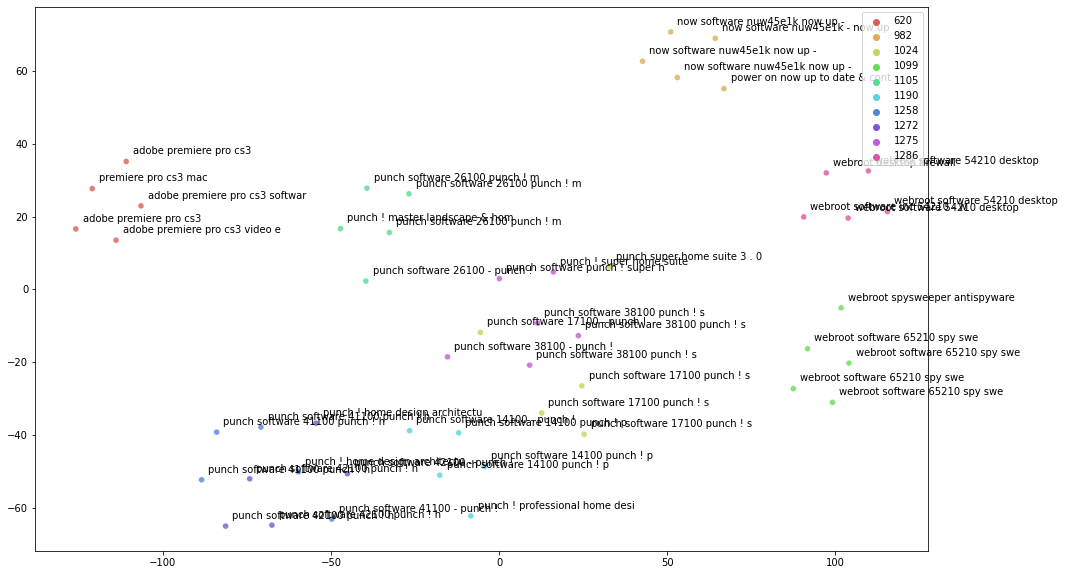

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)